# CV Analysis Test
Test the computer vision module for skin lesion segmentation and metric calculation.


In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Add cv-analysis to path
sys.path.insert(0, 'cv-analysis')
from module import run_cv_analysis


In [2]:
# Set image path
image_path = '/Users/tk20/Library/Application Support/pibu-ai/case_1765308032591/images/image_0001.png'

# Define bounding box: (x, y, width, height) or None for full image
# Example: bbox = (100, 100, 300, 300)
bbox = (1400, 1000, 1500, 1000)  # UPDATE THIS or set to None

# Run CV analysis
results = run_cv_analysis(image_path)

print("✅ Analysis complete!")
print(f"Bbox used: {bbox if bbox else 'Full image'}")


✅ Analysis complete!
Bbox used: (1400, 1000, 1500, 1000)


In [3]:
# Display Metrics
print("=" * 60)
print("METRICS")
print("=" * 60)

metrics = results['metrics']

# Shape metrics
if 'compactness_index' in metrics:
    print(f"\n📐 Shape Metrics:")
    print(f"  Compactness Index: {metrics['compactness_index']:.4f}")
    print(f"  (1.0 = perfect circle, higher = more irregular)")

# Color metrics
if 'color_stats_lab' in metrics:
    print(f"\n🎨 Color Statistics (LAB):")
    color = metrics['color_stats_lab']
    print(f"  Mean L (Lightness): {color['mean_L']:.2f}")
    print(f"  Mean A (Green-Red): {color['mean_A']:.2f}")
    print(f"  Mean B (Blue-Yellow): {color['mean_B']:.2f}")
    print(f"  Std L: {color['std_L']:.2f}")
    print(f"  Std A: {color['std_A']:.2f}")
    print(f"  Std B: {color['std_B']:.2f}")

# Size metrics
if metrics.get('area_cm2') is not None:
    print(f"\n📏 Size Metrics:")
    print(f"  Lesion Area: {metrics['area_cm2']:.4f} cm²")
    if metrics.get('area_cm2_uncorrected'):
        print(f"  Uncorrected Area: {metrics['area_cm2_uncorrected']:.4f} cm²")
    if metrics.get('tilt_correction_factor'):
        tilt = metrics['tilt_correction_factor']
        tilt_angle = np.arccos(tilt) * 180 / np.pi if tilt <= 1.0 else 0
        print(f"  Tilt Correction Factor: {tilt:.4f} (≈{tilt_angle:.1f}° angle)")
else:
    print(f"\n📏 Size Metrics:")
    print(f"  ⚠️  No coin detected - size in cm² not available")

# Coin detection
if results['coin_data']:
    print(f"\n🪙 Coin Detection:")
    cx, cy, r = results['coin_data']
    print(f"  Coin Center: ({cx}, {cy})")
    print(f"  Coin Radius: {r} px")
    if results['pixels_per_cm']:
        print(f"  Scale: {results['pixels_per_cm']:.2f} pixels/cm")
else:
    print(f"\n🪙 Coin Detection: Not detected")

print("\n" + "=" * 60)

METRICS

📐 Shape Metrics:
  Compactness Index: 1.6049
  (1.0 = perfect circle, higher = more irregular)

🎨 Color Statistics (LAB):
  Mean L (Lightness): 132.71
  Mean A (Green-Red): 137.32
  Mean B (Blue-Yellow): 119.00
  Std L: 9.47
  Std A: 1.36
  Std B: 2.31

📏 Size Metrics:
  Lesion Area: 0.1667 cm²
  Uncorrected Area: 0.1524 cm²
  Tilt Correction Factor: 0.9147 (≈23.8° angle)

🪙 Coin Detection:
  Coin Center: (391, 334)
  Coin Radius: 192 px
  Scale: 201.57 pixels/cm



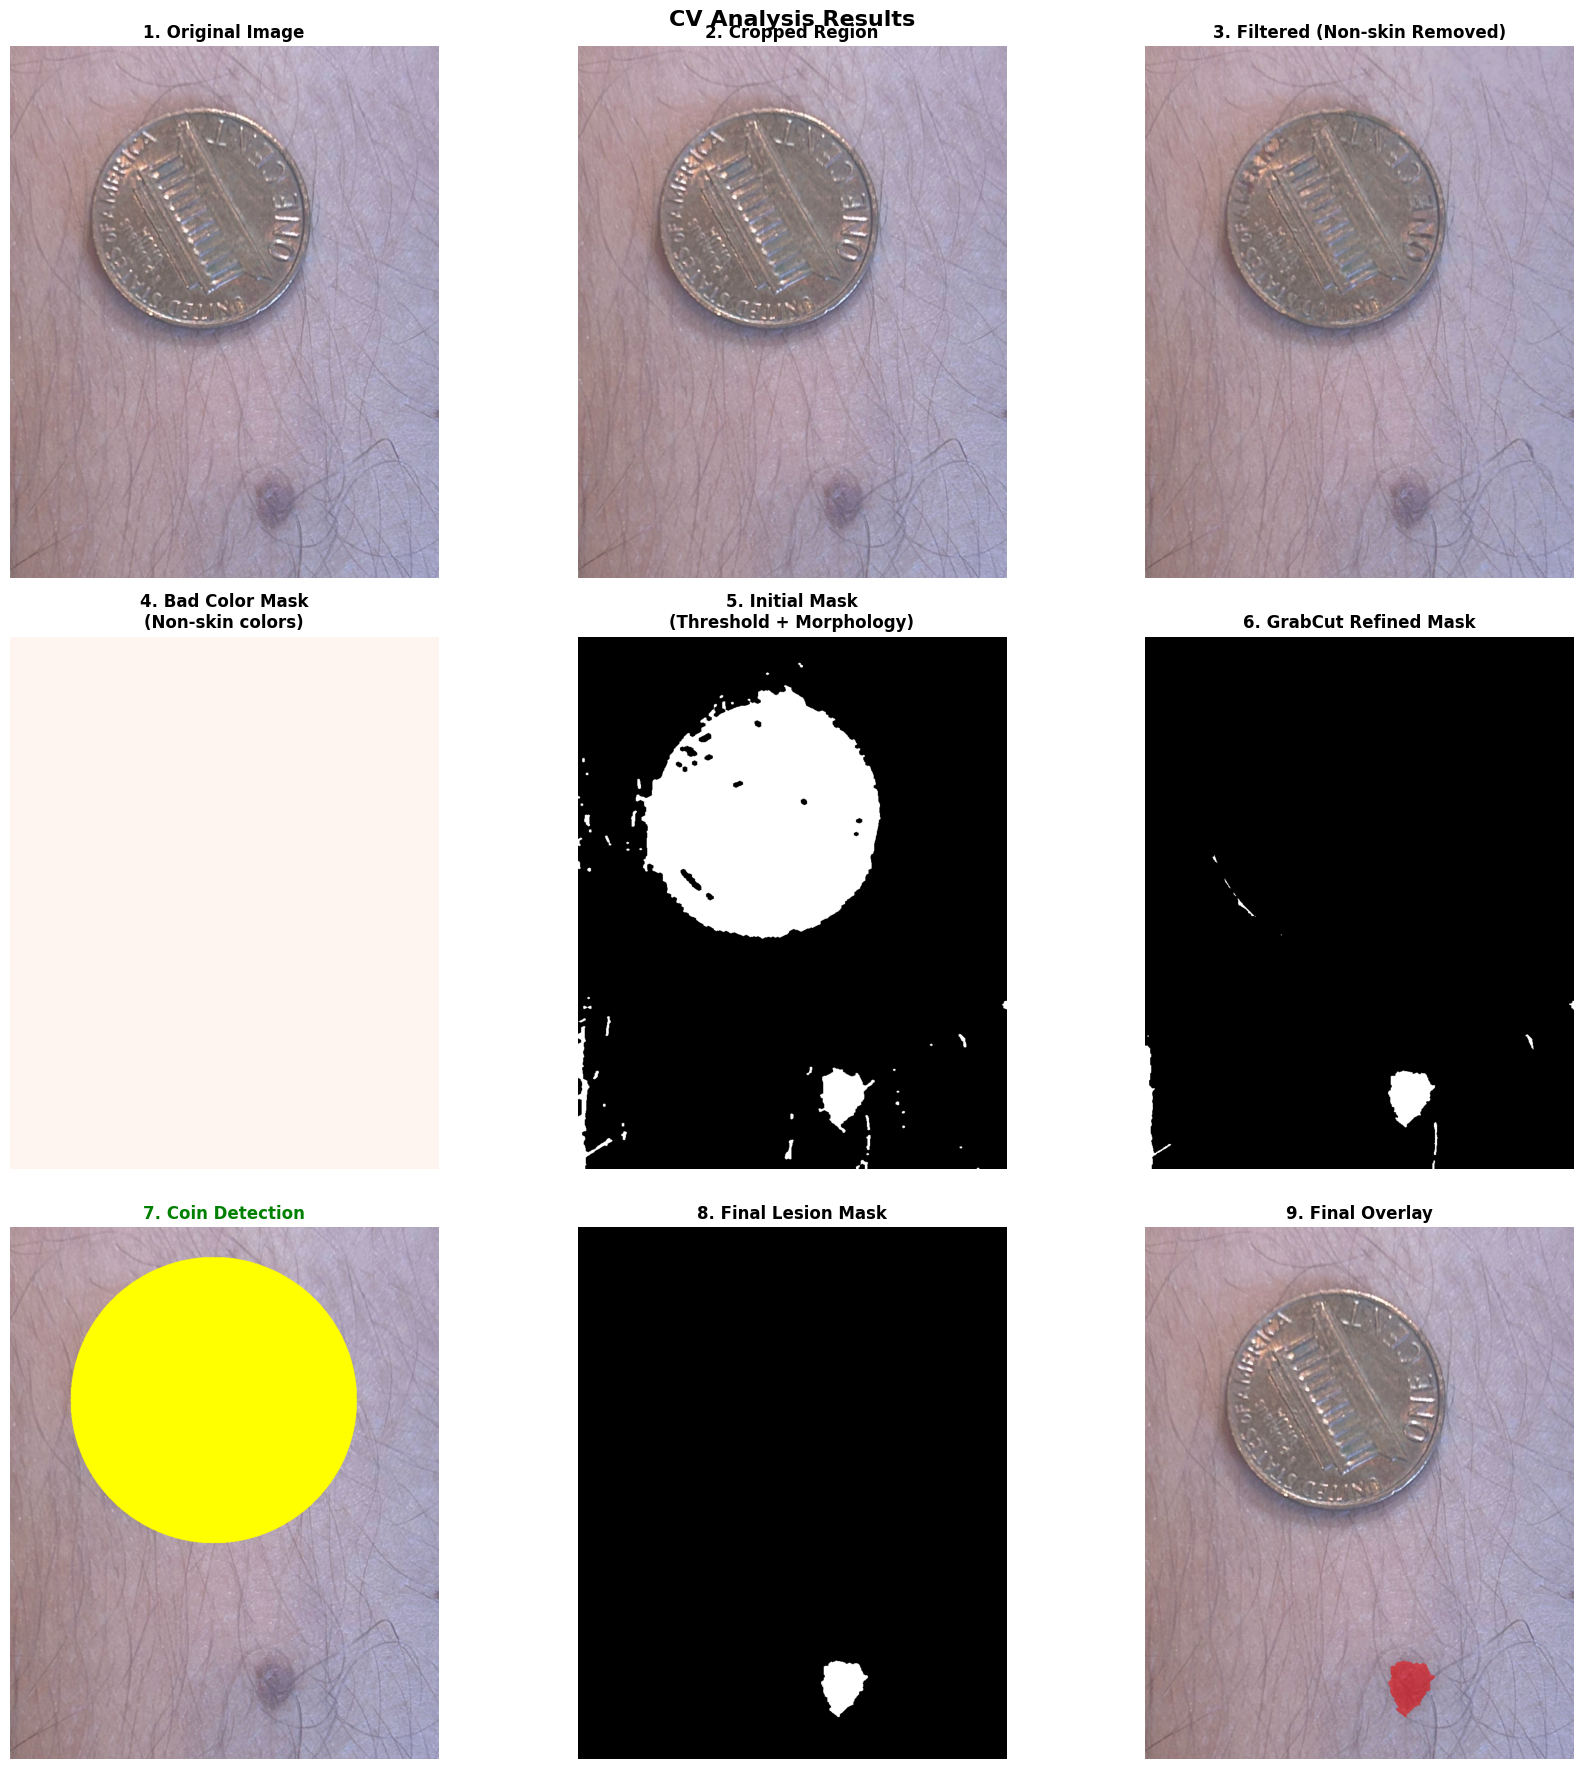

In [4]:
# Visualize Results
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('CV Analysis Results', fontsize=16, fontweight='bold')

# Extract images and masks
images = results['images']
masks = results['masks']

# Row 1: Original images
# 1. Original Image
ax = axes[0, 0]
original = cv2.cvtColor(images['original_image'], cv2.COLOR_BGR2RGB)
ax.imshow(original)
ax.set_title('1. Original Image', fontweight='bold')
ax.axis('off')

# 2. Cropped Image (if bbox was used)
ax = axes[0, 1]
cropped = cv2.cvtColor(images['cropped_image'], cv2.COLOR_BGR2RGB)
ax.imshow(cropped)
ax.set_title('2. Cropped Region', fontweight='bold')
ax.axis('off')

# 3. Filtered Image (non-skin colors removed)
ax = axes[0, 2]
filtered = cv2.cvtColor(images['filtered_image'], cv2.COLOR_BGR2RGB)
ax.imshow(filtered)
ax.set_title('3. Filtered (Non-skin Removed)', fontweight='bold')
ax.axis('off')

# Row 2: Masks
# 4. Bad Color Mask
ax = axes[1, 0]
ax.imshow(masks['bad_color_mask'], cmap='Reds')
ax.set_title('4. Bad Color Mask\n(Non-skin colors)', fontweight='bold')
ax.axis('off')

# 5. Initial Mask (after threshold)
ax = axes[1, 1]
ax.imshow(masks['initial_mask'], cmap='gray')
ax.set_title('5. Initial Mask\n(Threshold + Morphology)', fontweight='bold')
ax.axis('off')

# 6. GrabCut Mask
ax = axes[1, 2]
ax.imshow(masks['grabcut_mask'], cmap='gray')
ax.set_title('6. GrabCut Refined Mask', fontweight='bold')
ax.axis('off')

# Row 3: Final results
# 7. Coin Mask
ax = axes[2, 0]
if np.any(masks['coin_mask_full']):
    # Show coin on original image
    coin_overlay = original.copy()
    coin_overlay[masks['coin_mask_full'] > 0] = [255, 255, 0]  # Yellow
    ax.imshow(coin_overlay)
    ax.set_title('7. Coin Detection', fontweight='bold', color='green')
else:
    ax.imshow(original)
    ax.set_title('7. Coin Detection\n(Not Found)', fontweight='bold', color='red')
ax.axis('off')

# 8. Final Lesion Mask
ax = axes[2, 1]
ax.imshow(masks['final_mask'], cmap='gray')
ax.set_title('8. Final Lesion Mask', fontweight='bold')
ax.axis('off')

# 9. Overlay on Original
ax = axes[2, 2]
overlay = cropped.copy()
mask_to_use = masks['final_mask']
    
# Create colored overlay
overlay[mask_to_use > 0] = overlay[mask_to_use > 0] * 0.5 + np.array([255, 0, 0]) * 0.5  # Red tint
ax.imshow(overlay)
ax.set_title('9. Final Overlay', fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

METRICS

📐 Shape Metrics:
  Compactness Index: 1.4424
  (1.0 = perfect circle, higher = more irregular)

🎨 Color Statistics (LAB):
  Mean L (Lightness): 133.88
  Mean A (Green-Red): 133.61
  Mean B (Blue-Yellow): 128.64
  Std L: 14.19
  Std A: 2.51
  Std B: 4.88

📏 Size Metrics:
  Lesion Area: 45.9110 cm²
  Uncorrected Area: 45.9110 cm²
  Tilt Correction Factor: 1.0000 (≈0.0° angle)

🪙 Coin Detection:
  Coin Center: (226, 398)
  Coin Radius: 56 px
  Scale: 58.79 pixels/cm



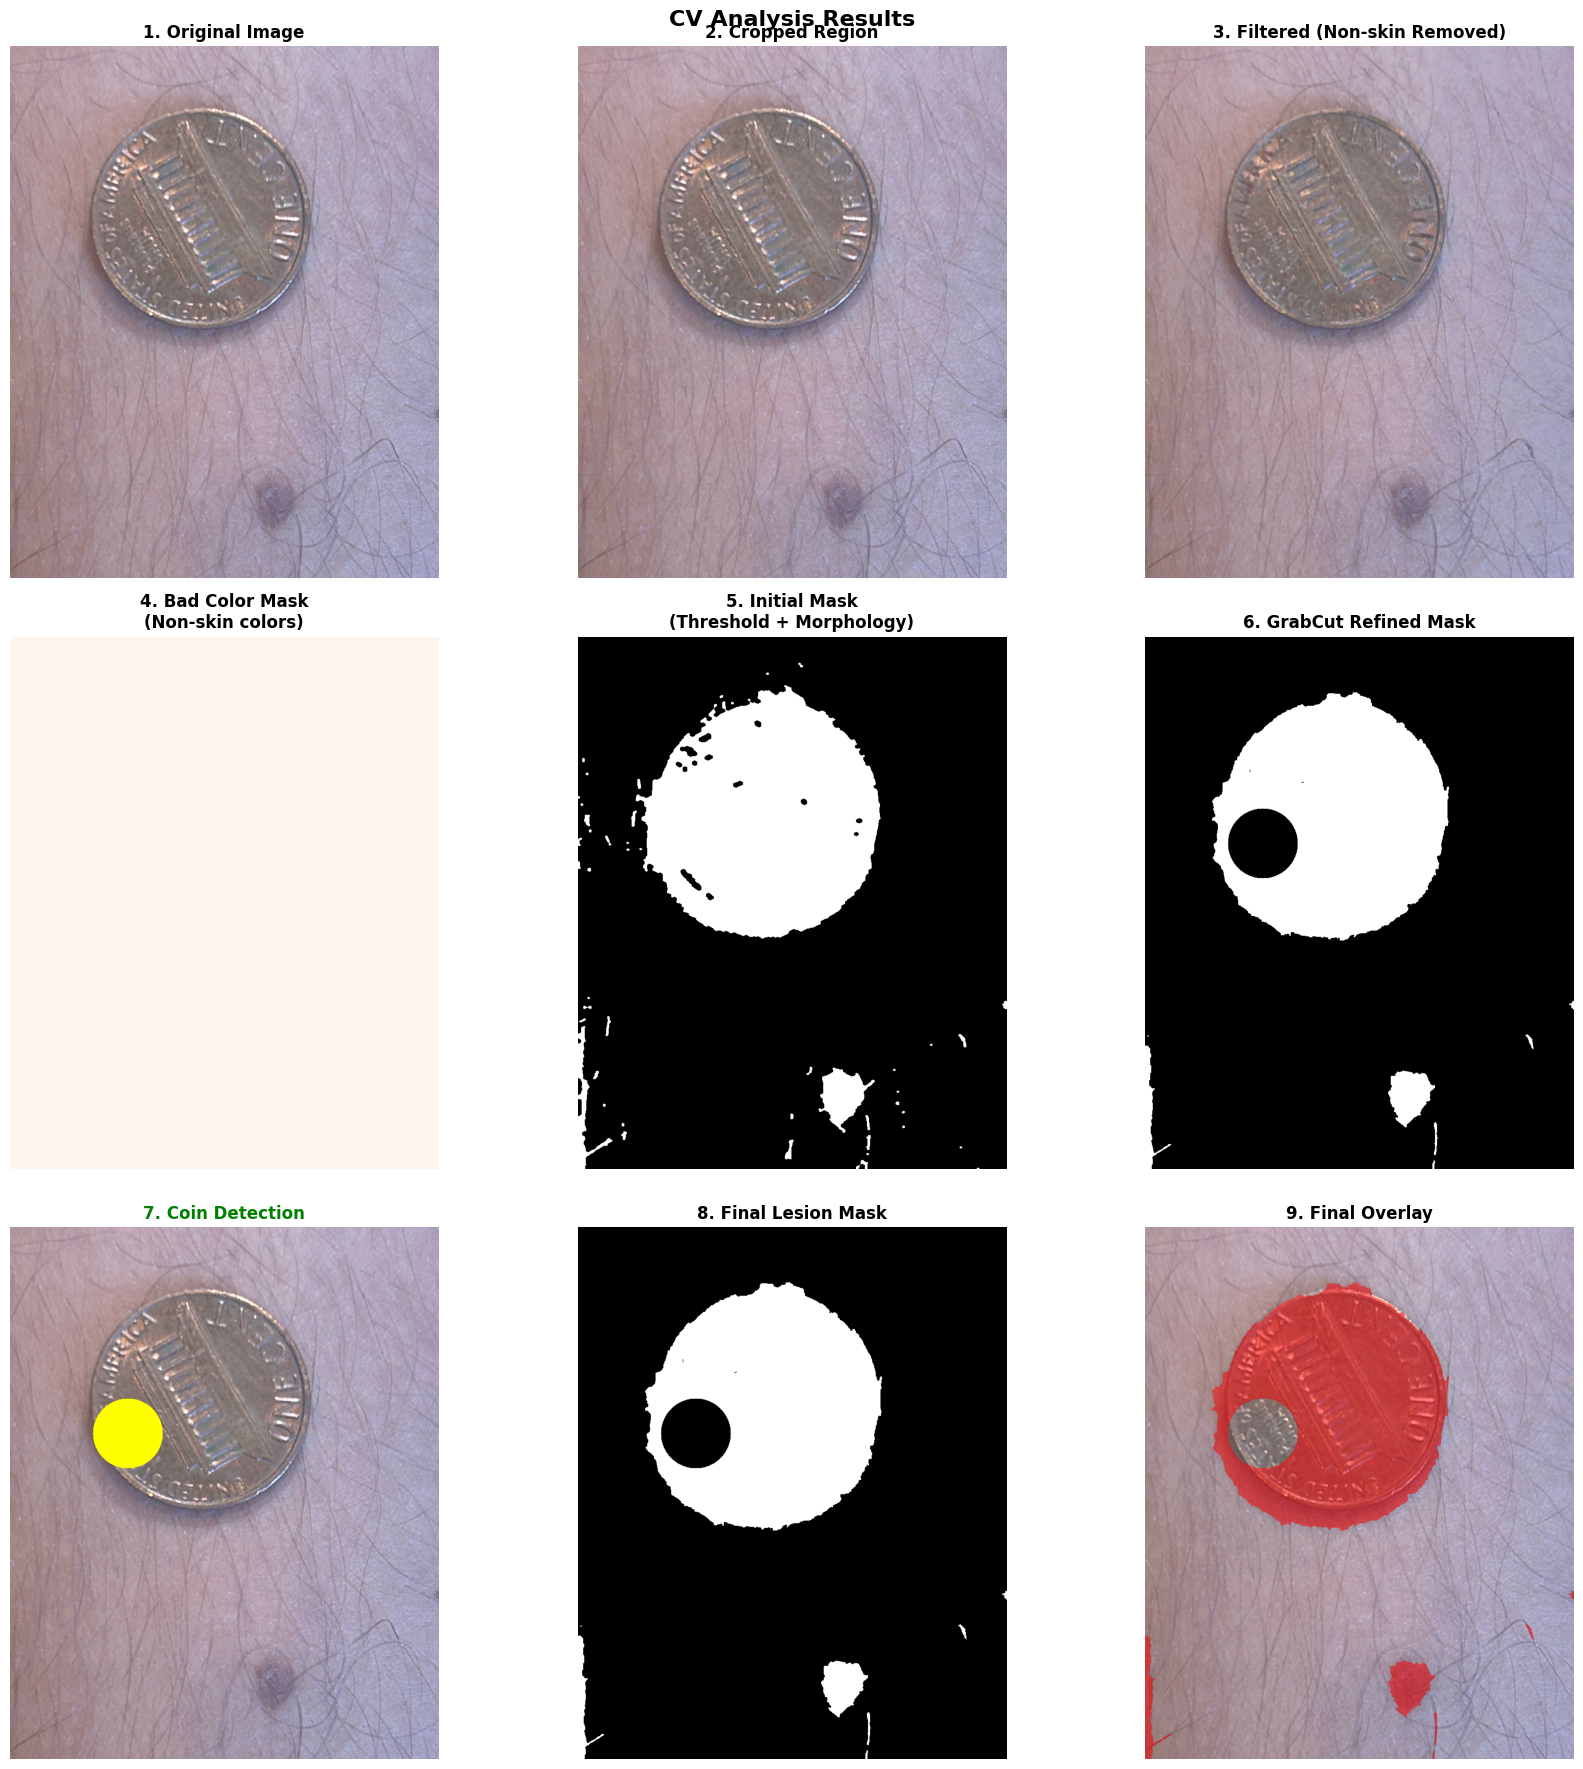

✓ Image found at: /Users/tk20/Desktop/APCOMP215/data/sample_imgs/trial/a.png


/Users/tk20/Desktop/APCOMP215/ac215_Group_127_2473879/src/frontend-react/python/test_cv_analysis_001
No case history file found for case test_cv_analysis_001, using default.
No conversation history file found for case test_cv_analysis_001, using default.
No demographics file found for case test_cv_analysis_001, using default.


Initialized API Manager for case: test_cv_analysis_001


    Running CV analysis on: /Users/tk20/Desktop/APCOMP215/data/sample_imgs/trial/a.png


Running CV analysis...


    ✓ CV analysis complete
    Metrics: {'compactness_index': 7.793015138374817, 'color_stats_lab': {'mean_L': 97.50898065172332, 'mean_A': 139.1335732283343, 'mean_B': 149.33476140207583, 'std_L': 23.84394686179632, 'std_A': 3.762945670075602, 'std_B': 2.9665262673640056}, 'area_cm2': 20.29215199863236, 'area_cm2_uncorrected': 19.35286141826923, 'tilt_correction_factor': 0.9537116329294973}



CV Analysis Results:
{
  "metrics": {
    "compactness_index": 7.793015138374817,
    "color_stats_lab": {
      "mean_L": 97.50898065172332,
      "mean_A": 139.1335732283343,
      "mean_B": 149.33476140207583,
      "std_L": 23.84394686179632,
      "std_A": 3.762945670075602,
      "std_B": 2.9665262673640056
    },
    "area_cm2": 20.29215199863236,
    "area_cm2_uncorrected": 19.35286141826923,
    "tilt_correction_factor": 0.9537116329294973
  },
  "bbox": [
    0,
    0,
    1024,
    558
  ],
  "coin_data": [
    752,
    271,
    78
  ],
  "pixels_per_cm": 81.88976377952756,
  "tilt_correction": 0.9537116329294973
}
